In [1]:
import tensorflow as tf
import torch 
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

2025-03-13 18:50:15.907835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 18:50:15.945987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df= pd.read_csv('train.csv',index_col='StudentID') 
test_df = pd.read_csv('test.csv', index_col='StudentID')

In [3]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1530 entries, 3321 to 2747
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1530 non-null   int64  
 1   Gender             1530 non-null   int64  
 2   Ethnicity          1530 non-null   object 
 3   ParentalEducation  1388 non-null   object 
 4   StudyTimeWeekly    1530 non-null   float64
 5   Absences           1530 non-null   int64  
 6   Tutoring           1530 non-null   int64  
 7   ParentalSupport    1398 non-null   object 
 8   Extracurricular    1530 non-null   int64  
 9   Sports             1530 non-null   int64  
 10  Music              1530 non-null   int64  
 11  Volunteering       1530 non-null   int64  
 12  GPA                1530 non-null   float64
dtypes: float64(2), int64(8), object(3)
memory usage: 167.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 2340 to 1592
Data columns (total 13 columns):
 #   Co

In [4]:
# select the rows which have N/A values 
combine_df = pd.concat([train_df,
                        test_df])

combine_df[combine_df.isnull().any(axis=1)]

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
StudentID,,,,,,,,,,,,,
2644,16,0,Other,Some College,6.845312,13,0,NaN,0,0,1,0,1.852672
2811,16,1,Caucasian,Some College,7.520836,5,0,NaN,0,0,0,0,2.631368
1687,16,0,Caucasian,Some College,0.184018,11,1,NaN,1,0,0,0,1.810409
1294,16,0,Caucasian,High School,6.682860,6,1,NaN,0,0,0,1,2.546517
2034,16,1,African American,Some College,3.153221,13,1,NaN,0,1,0,0,2.058575
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,17,0,Asian,NaN,1.915084,18,0,Moderate,0,1,0,1,1.199651
2426,16,1,Asian,NaN,14.283063,13,1,Low,0,0,0,0,1.880065
1475,17,1,African American,Some College,1.444587,24,0,NaN,0,0,0,0,0.000000


In [5]:
# Ensure 'ParentalEducation' is ordered correctly
education_order = ['High School', 'Bachelor', 'Some College', 'Higher']
combine_df['ParentalEducation'] = pd.Categorical(
    combine_df['ParentalEducation'],
    categories=education_order,
    ordered=True
)

support_order = ['Low','Moderate','High','Very High']
combine_df['ParentalSupport'] = pd.Categorical(
    combine_df['ParentalSupport'],
    categories=support_order,
    ordered=True
)

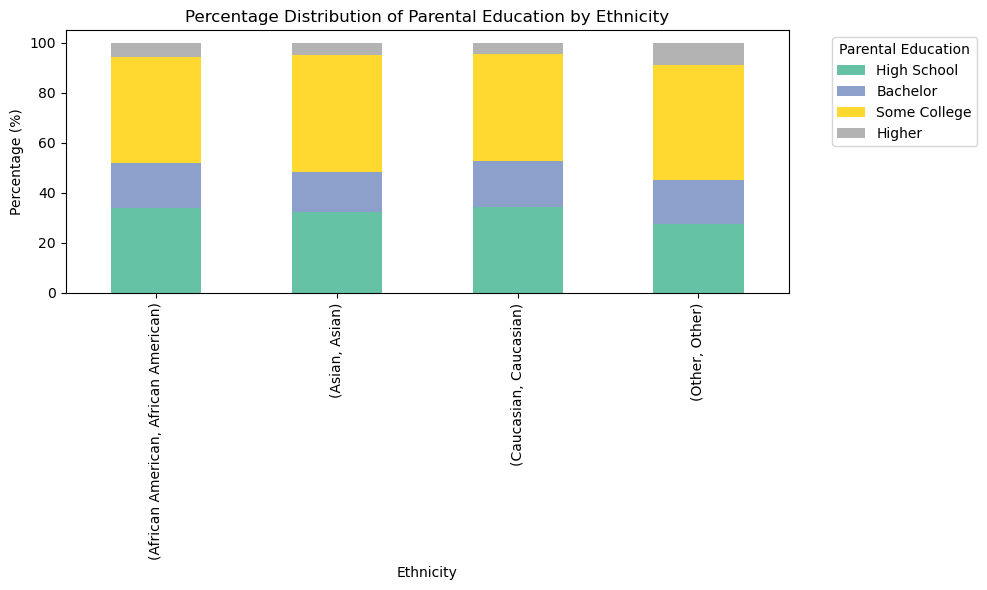

In [6]:
# visualize the relationship between Ethinicity and ParentalEducation
percentages = (
    combine_df.groupby(['Ethnicity', 'ParentalEducation'],
                       observed=True).size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Other families are more educated. But not much difference

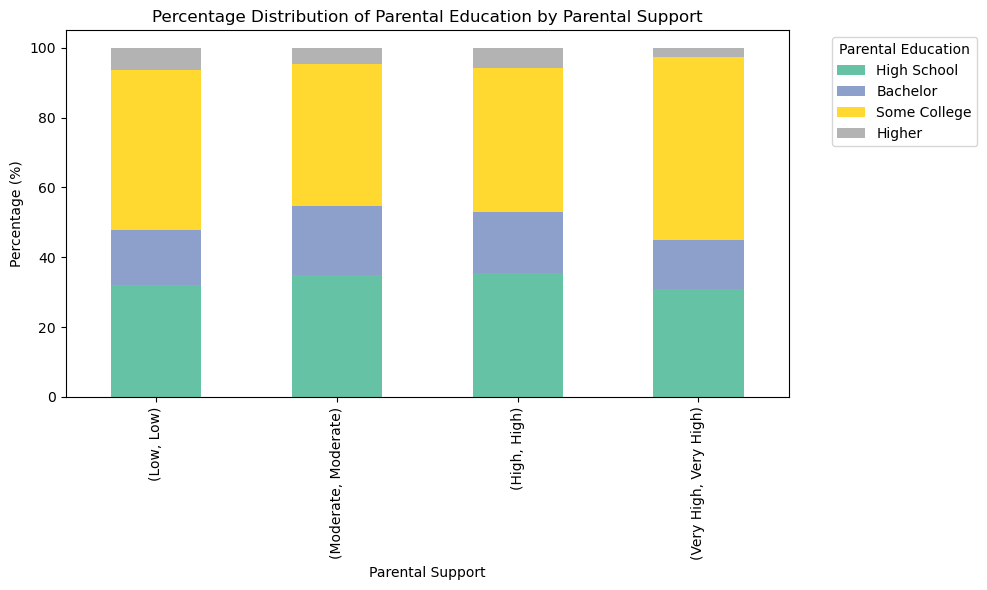

In [7]:
# visualize the relationship between ParentalSupport and ParentalEducation
percentages_support = (
    combine_df.groupby(
        ['ParentalSupport', 'ParentalEducation'], observed=True).size()
    .groupby(level=0,observed=True)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages_support.plot(kind='bar', stacked=True,
                         figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Parental Support')
plt.xlabel('Parental Support')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

seem's like more educated families are more supportive. But it's not considerable

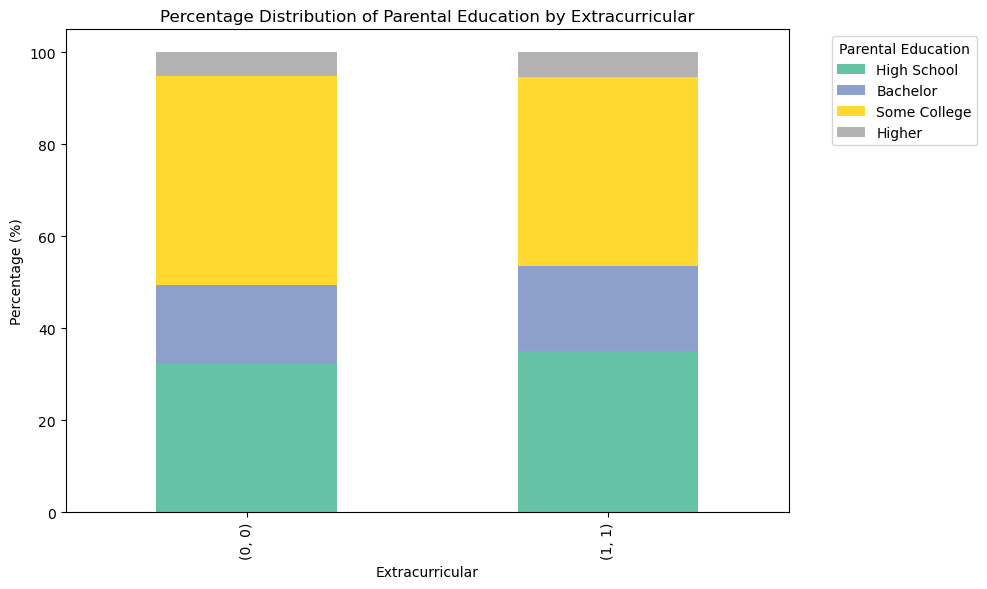

In [8]:
# visualize the relationship between Extracurricular and ParentalEducation
percentages_extra = (
    combine_df.groupby(['Extracurricular', 'ParentalEducation'],observed=True).size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages_extra.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Extracurricular')
plt.xlabel('Extracurricular')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

I can guess that more educated families are not intrested in Extracurricular.

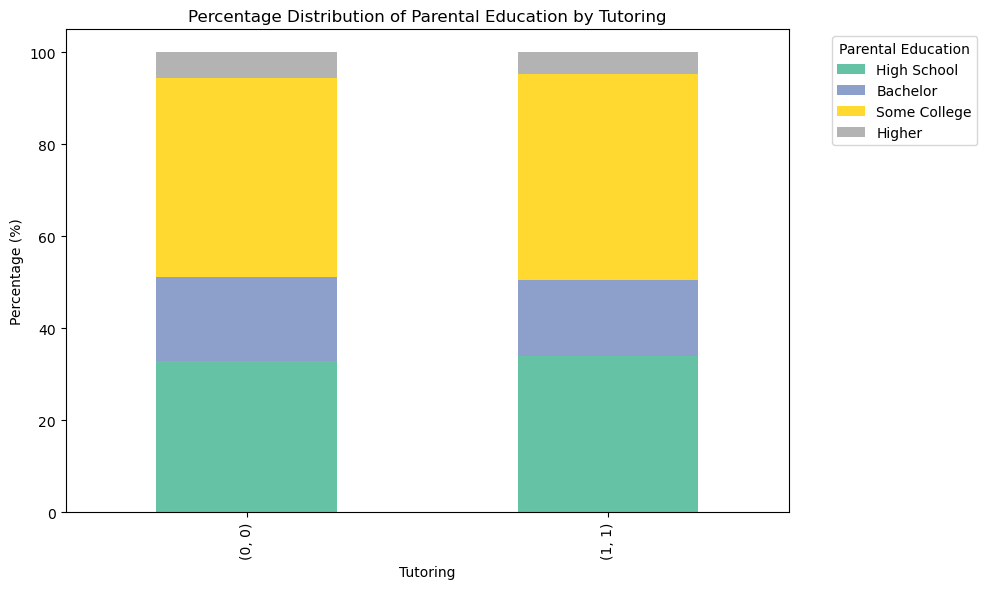

In [9]:
# visualize the relationship between Tutoring and ParentalEducation
percentages_extra = (
    combine_df.groupby(
        ['Tutoring', 'ParentalEducation'], observed=True).size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages_extra.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Tutoring')
plt.xlabel('Tutoring')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Analyze the result
it seems like the data "The dataset exhibits a high degree of variability, with no clear trends or correlations between variables such as family education levels and parental support. Also there are few rows with N/A values. So I will drop them

In [10]:
#drop N/A rows
train_df = train_df.dropna()
test_df = test_df.dropna()
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1269 entries, 3321 to 2747
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1269 non-null   int64  
 1   Gender             1269 non-null   int64  
 2   Ethnicity          1269 non-null   object 
 3   ParentalEducation  1269 non-null   object 
 4   StudyTimeWeekly    1269 non-null   float64
 5   Absences           1269 non-null   int64  
 6   Tutoring           1269 non-null   int64  
 7   ParentalSupport    1269 non-null   object 
 8   Extracurricular    1269 non-null   int64  
 9   Sports             1269 non-null   int64  
 10  Music              1269 non-null   int64  
 11  Volunteering       1269 non-null   int64  
 12  GPA                1269 non-null   float64
dtypes: float64(2), int64(8), object(3)
memory usage: 138.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 2340 to 1592
Data columns (total 13 columns):
 #   Co

In [11]:
# convert categorical data to numerical data 

education_mapping = {edu: idx for idx, edu in enumerate(education_order)}
support_mapping = {sup: idx for idx, sup in enumerate(support_order)}

train_df['ParentalEducation'] = train_df['ParentalEducation'].map(education_mapping)
test_df['ParentalEducation'] = test_df['ParentalEducation'].map(education_mapping)

train_df['ParentalSupport'] = train_df['ParentalSupport'].map(support_mapping)
test_df['ParentalSupport'] = test_df['ParentalSupport'].map(support_mapping)

In [12]:
#one-hot encoding for Ethnicity
train_df = pd.get_dummies(train_df, columns=['Ethnicity'],prefix='Ethnicity').astype('float')
test_df = pd.get_dummies(test_df, columns=['Ethnicity'], prefix='Ethnicity').astype('float')

In [13]:
train_df

,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Other
StudentID,,,,,,,,,,,,,,,,
3321,17.0,1.0,0.0,9.906353,25.0,0.0,2.0,1.0,1.0,0.0,0.0,1.082390,0.0,0.0,1.0,0.0
1160,18.0,0.0,0.0,4.681156,20.0,0.0,2.0,0.0,0.0,0.0,1.0,1.189549,0.0,0.0,1.0,0.0
2321,18.0,0.0,0.0,19.885760,2.0,0.0,2.0,1.0,0.0,0.0,0.0,3.517237,0.0,1.0,0.0,0.0
2419,15.0,1.0,1.0,14.806261,20.0,0.0,3.0,0.0,0.0,0.0,0.0,1.582093,1.0,0.0,0.0,0.0
1266,16.0,1.0,2.0,1.502859,10.0,1.0,2.0,0.0,0.0,0.0,0.0,2.150233,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,18.0,0.0,2.0,19.088954,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.825020,0.0,0.0,0.0,1.0
2740,17.0,0.0,0.0,9.657889,16.0,0.0,1.0,1.0,1.0,0.0,0.0,1.811622,0.0,0.0,1.0,0.0
2535,17.0,0.0,2.0,16.119403,18.0,1.0,2.0,0.0,0.0,0.0,0.0,1.844059,1.0,0.0,0.0,0.0


In [14]:
test_df

,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Other
StudentID,,,,,,,,,,,,,,,,
2340,16.0,1.0,3.0,5.044048,25.0,1.0,1.0,1.0,0.0,0.0,0.0,0.886889,0.0,0.0,0.0,1.0
2923,18.0,0.0,1.0,18.731312,12.0,0.0,1.0,1.0,0.0,0.0,0.0,2.234696,0.0,0.0,0.0,1.0
2077,16.0,0.0,2.0,0.213403,23.0,1.0,1.0,0.0,1.0,0.0,0.0,0.875367,0.0,1.0,0.0,0.0
2735,15.0,1.0,3.0,14.645811,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.648705,1.0,0.0,0.0,0.0
2245,17.0,0.0,2.0,11.436575,1.0,0.0,2.0,1.0,0.0,0.0,0.0,3.463688,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,15.0,0.0,2.0,8.991978,10.0,1.0,2.0,1.0,0.0,0.0,0.0,2.830404,0.0,0.0,1.0,0.0
1929,16.0,1.0,2.0,16.023430,4.0,1.0,1.0,1.0,1.0,0.0,0.0,3.262270,1.0,0.0,0.0,0.0
2280,18.0,1.0,2.0,2.832227,18.0,1.0,3.0,1.0,0.0,0.0,0.0,1.419523,0.0,0.0,1.0,0.0


In [15]:
# Identify all numeric columns (excluding 'Survived')
numeric_cols = train_df.select_dtypes(
    include=['float64', 'int64']).columns.difference(['Survived'])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the train dataset
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

# Transform the test dataset
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1269 entries, 3321 to 2747
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         1269 non-null   float64
 1   Gender                      1269 non-null   float64
 2   ParentalEducation           1269 non-null   float64
 3   StudyTimeWeekly             1269 non-null   float64
 4   Absences                    1269 non-null   float64
 5   Tutoring                    1269 non-null   float64
 6   ParentalSupport             1269 non-null   float64
 7   Extracurricular             1269 non-null   float64
 8   Sports                      1269 non-null   float64
 9   Music                       1269 non-null   float64
 10  Volunteering                1269 non-null   float64
 11  GPA                         1269 non-null   float64
 12  Ethnicity_African American  1269 non-null   float64
 13  Ethnicity_Asian             1269 no

In [16]:
x_train = train_df.drop('GPA', axis=1).values
y_train = train_df['GPA'].values
x_test = test_df.drop('GPA', axis=1).values
y_test = test_df['GPA'].values

In [17]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32) 
y_test = torch.tensor(y_test, dtype=torch.float32)
y_train = y_train.view(-1, 1) 
y_test = y_test.view(-1, 1)  
x_train.shape

torch.Size([1269, 15])

## Building The NN

In [18]:
# Define the neural network
class GPAPredictor(nn.Module):
    def __init__(self, input_size):
        super(GPAPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)
    

In [19]:
def evaluate_loss_r2(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            predictions.extend(outputs.numpy().flatten())
            actuals.extend(targets.numpy().flatten())

    r2 = r2_score(actuals, predictions)
    return test_loss / len(test_loader), r2

In [20]:
train_losses = []
test_losses = []
r2_scores = []
def train_model(model, train_loader, test_loader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        test_loss, r2 = evaluate_loss_r2(model, test_loader, criterion)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        r2_scores.append(r2)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, R²: {r2:.4f}")

In [21]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy().flatten())
            actuals.extend(targets.numpy().flatten())

    r2 = r2_score(actuals, predictions)
    print(f"R^2 Score: {r2:.4f}")
    return r2

In [22]:
input_size = x_train.shape[1]  
model = GPAPredictor(input_size)
    

# Training
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# Testing
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    


In [23]:
epochs = 10
train_model(model, train_loader, test_loader=test_loader,
            epochs=epochs, lr=0.0005)
evaluate_model(model, test_loader)

Epoch [1/10] - Train Loss: 0.3018, Test Loss: 0.1184, R²: -1.2524
Epoch [2/10] - Train Loss: 0.0670, Test Loss: 0.0469, R²: 0.1060
Epoch [3/10] - Train Loss: 0.0445, Test Loss: 0.0400, R²: 0.2392
Epoch [4/10] - Train Loss: 0.0381, Test Loss: 0.0342, R²: 0.3484
Epoch [5/10] - Train Loss: 0.0310, Test Loss: 0.0270, R²: 0.4861
Epoch [6/10] - Train Loss: 0.0236, Test Loss: 0.0199, R²: 0.6219
Epoch [7/10] - Train Loss: 0.0165, Test Loss: 0.0131, R²: 0.7497
Epoch [8/10] - Train Loss: 0.0104, Test Loss: 0.0081, R²: 0.8461
Epoch [9/10] - Train Loss: 0.0065, Test Loss: 0.0052, R²: 0.9016
Epoch [10/10] - Train Loss: 0.0046, Test Loss: 0.0040, R²: 0.9234
R^2 Score: 0.9234


0.9234066557827835

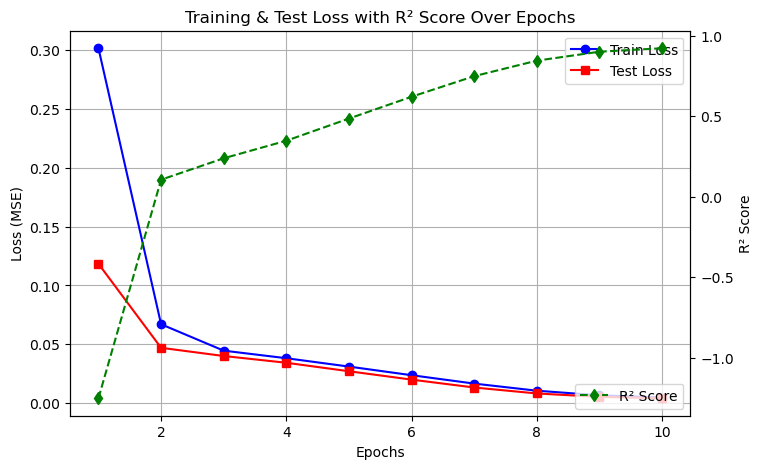

In [24]:

# Plot loss curves and R² score
fig, ax1 = plt.subplots(figsize=(8, 5))

# Loss plot
ax1.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker="o", color="blue")
ax1.plot(range(1, epochs + 1), test_losses, label="Test Loss", marker="s", color="red")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss (MSE)")
ax1.legend(loc="upper right")
ax1.grid()

# R² score plot
ax2 = ax1.twinx()  
ax2.plot(range(1, epochs + 1), r2_scores, label="R² Score", marker="d", linestyle="dashed", color="green")
ax2.set_ylabel("R² Score")
ax2.legend(loc="lower right")

plt.title("Training & Test Loss with R² Score Over Epochs")
plt.show()